In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from sklearn.preprocessing import MinMaxScaler


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [36]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [37]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [38]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

In [39]:
scaler = MinMaxScaler((0.3, np.pi-0.3))
conjunto_train = scaler.fit_transform(conjunto_train)

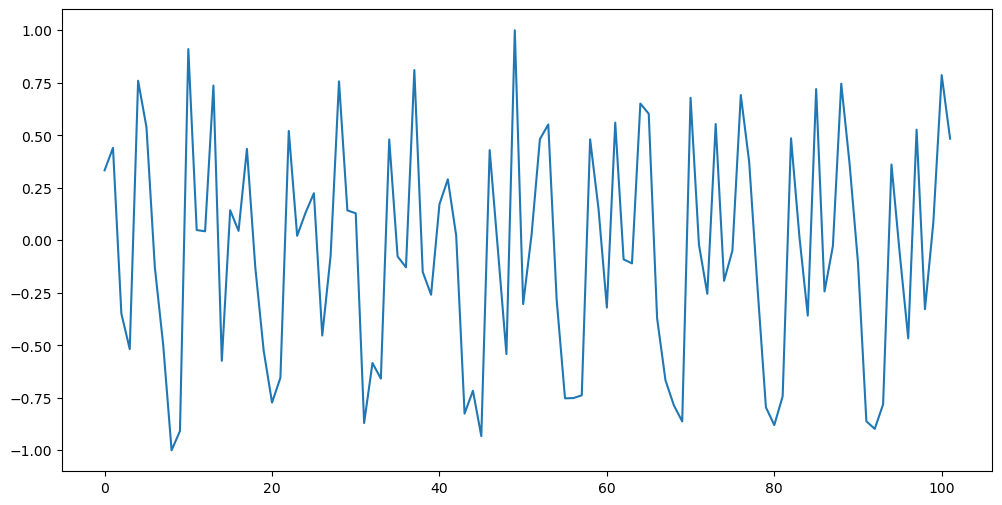

In [40]:
objetivo_train = (-2/(np.min(objetivo_train) - np.max(objetivo_train)))*objetivo_train - 1 + np.min(objetivo_train)*(2/(np.min(objetivo_train) - np.max(objetivo_train)))
plt.plot(objetivo_train)
plt.show()

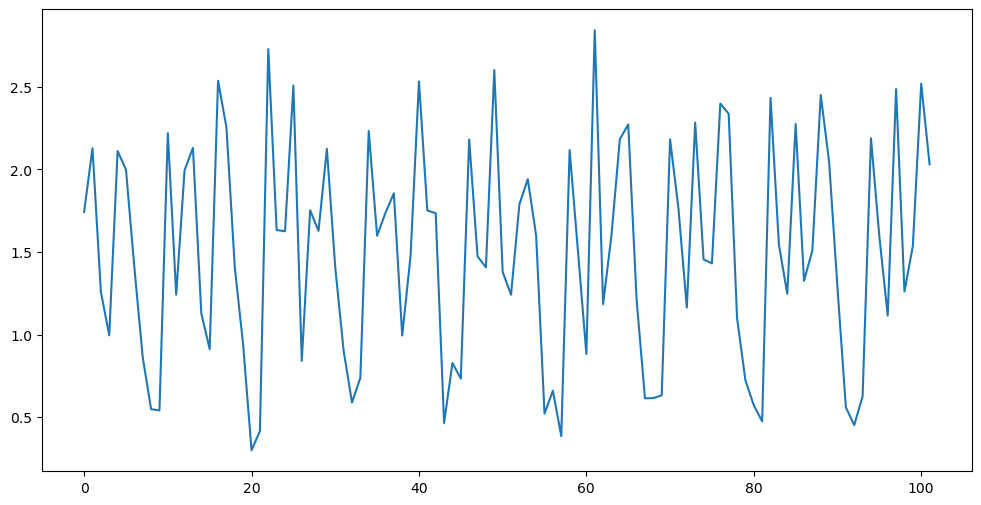

In [41]:
plt.plot(conjunto_train[:,0])
plt.show()

In [42]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    qc = QuantumCircuit(n_qubits)
    
    inputs = ParameterVector("inputs",n_qubits)
    pesos = ParameterVector("pesos",2*n_qubits)
    feature_map = QuantumCircuit(n_qubits)
    feature_map.h(range(n_qubits))
    
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
        
    for i in range(n_qubits-1):
        feature_map.cx(i,i+1)
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
    
    ansatz = RealAmplitudes(n_qubits,reps=8)
    #ansatz = QuantumCircuit(n_qubits)
    #for i in range(n_qubits):
    #    ansatz.ry(pesos[i],i)
    #    
    #for i in range(n_qubits-1):
    #    ansatz.cz(i,i+1)
    #
    #for i in range(n_qubits,2*n_qubits):
    #    ansatz.ry(pesos[i],i-n_qubits)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(QFT(n_qubits, inverse = True), inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [43]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(window)

In [44]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [45]:
modeloEstimator = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params
    )

In [46]:
regressor = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error' ,
    optimizer=COBYLA(maxiter=2000),
    callback=callback_graph
)

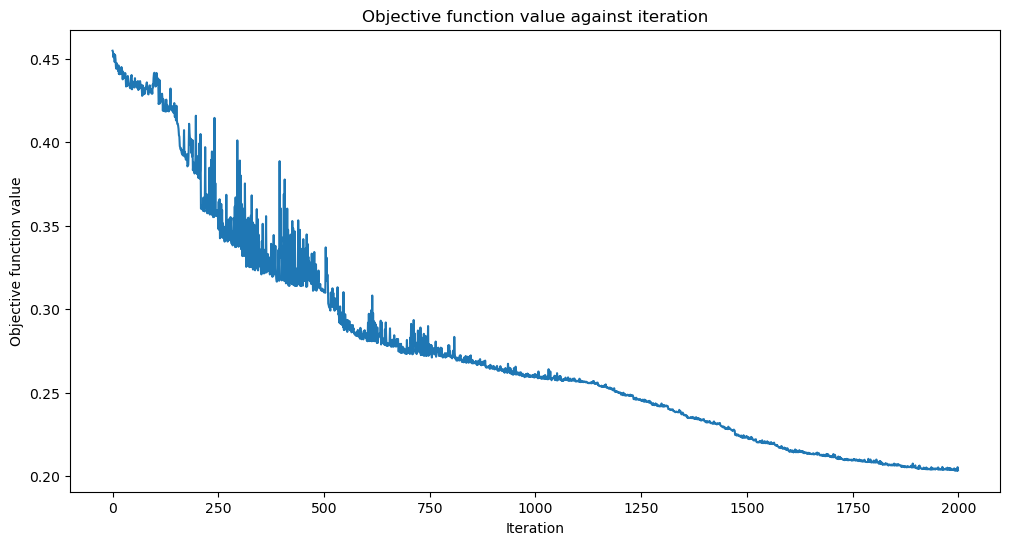

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)
regressor.score(conjunto_train, objetivo_train)

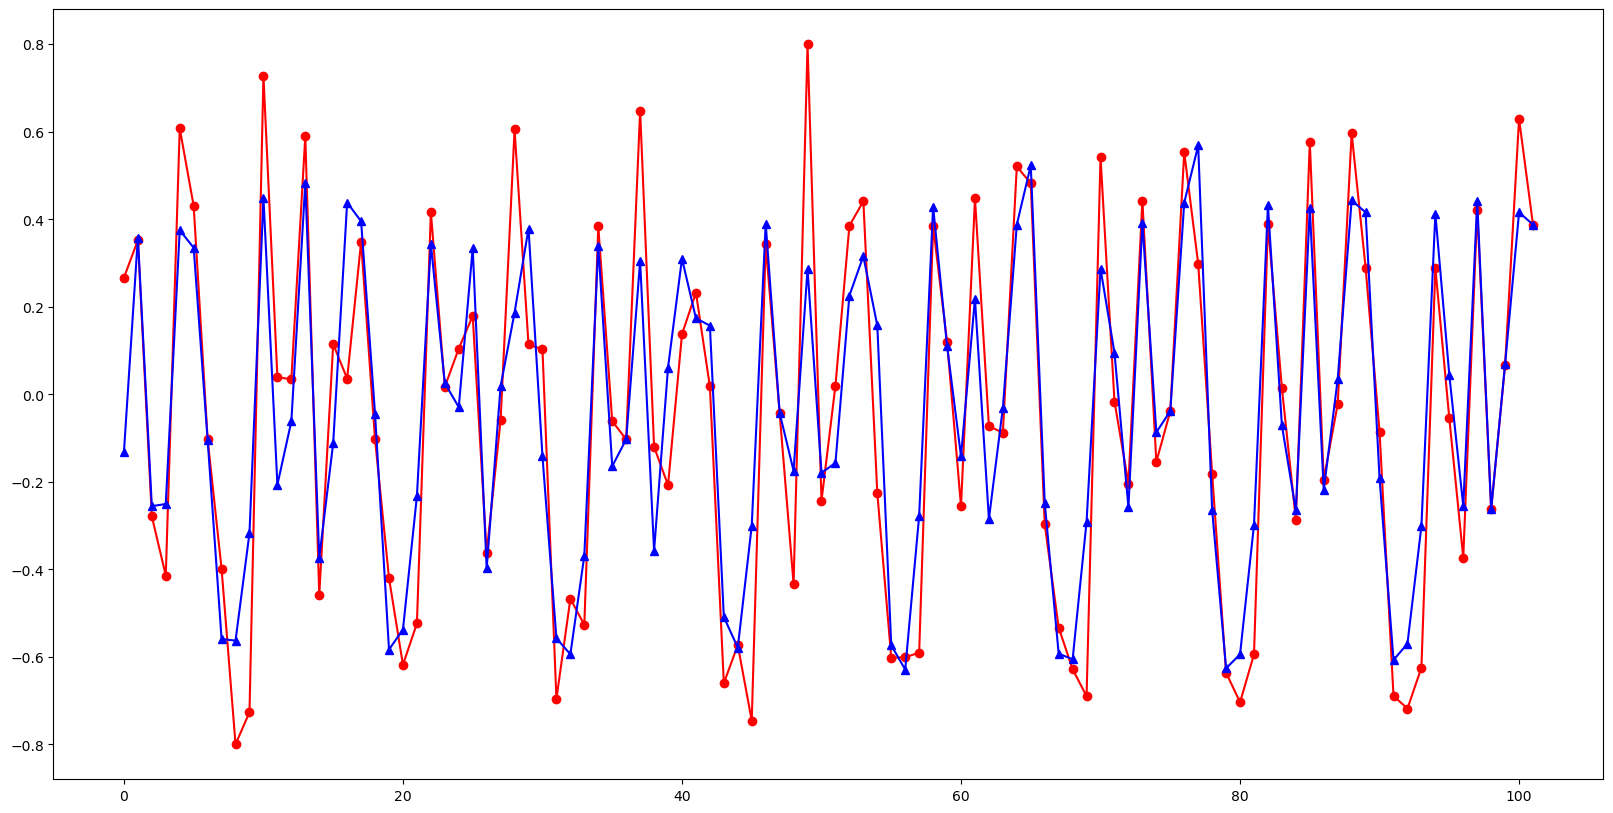

array([ 1.94242935,  1.58437795,  0.59998496,  1.22565426,  1.19314064,
        0.83218266,  0.43205923,  0.86854975,  2.47389261,  1.67176941,
       -0.47300588,  2.61972282, -0.49496317,  0.03286625,  0.50856688,
        0.70089565, -0.03434475, -0.63534547,  0.31407747,  0.74590977,
        1.423272  ,  1.15507966, -0.10635813, -0.27591607,  0.85116555,
       -0.20972884, -0.43207564,  0.58997862,  1.50046386,  0.3417065 ,
        1.95478596,  2.5297755 ,  1.62923447,  2.11253133,  2.04457118,
        0.53767052,  0.2191619 ,  0.97056719,  0.27816285,  2.13998171,
        0.23925232,  1.8503885 ,  0.99902573,  1.04744255,  1.35420742,
        0.89779911,  1.68505687,  0.11699715,  1.4861454 ,  2.23660136,
        2.2532449 ,  1.94826995,  1.6344896 ,  1.27702023, -0.24735636,
        1.83241876,  0.29471712,  0.90408146, -0.26174722,  0.07062033,
        1.03523866,  1.78965515,  1.5538426 ,  0.02339807,  0.13060882,
       -1.2988744 , -0.14467449,  0.45772834,  1.04951067, -1.20

In [14]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.weights

In [15]:
np.sum( np.abs(objetivo_train[:] - y_[:]))/(len(objetivo_train))

45.885728635457895

In [23]:
### NO HAY QUE HACER TRANSFORM conjunto_test = scaler.fit_transform(conjunto_test)
conjunto_test = scaler.fit_transform(conjunto_test)

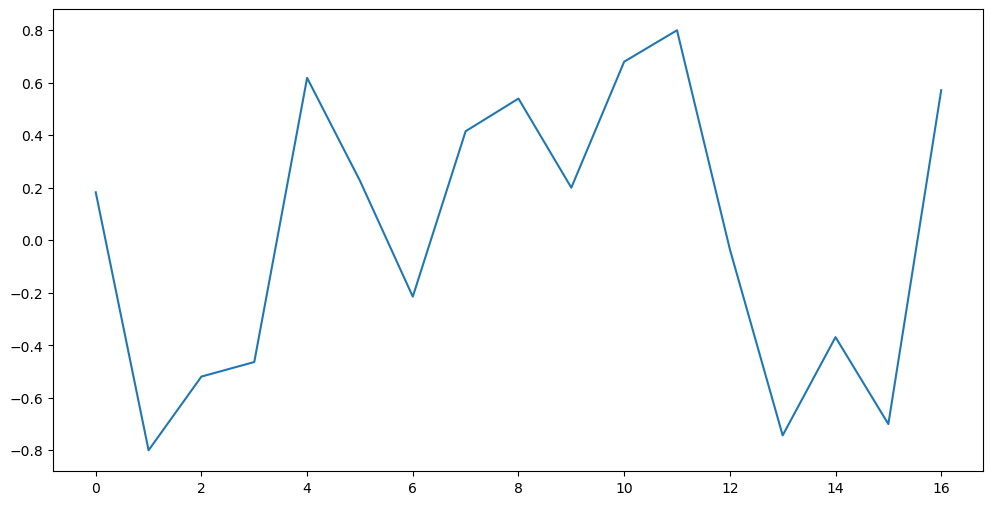

0.6003606993763106

In [24]:
objetivo_test = (-1.6/(np.min(objetivo_test) - np.max(objetivo_test)))*objetivo_test - 0.8 + np.min(objetivo_test)*(1.6/(np.min(objetivo_test) - np.max(objetivo_test)))
plt.plot(objetivo_test)
plt.show()
regressor.score(conjunto_test, objetivo_test)

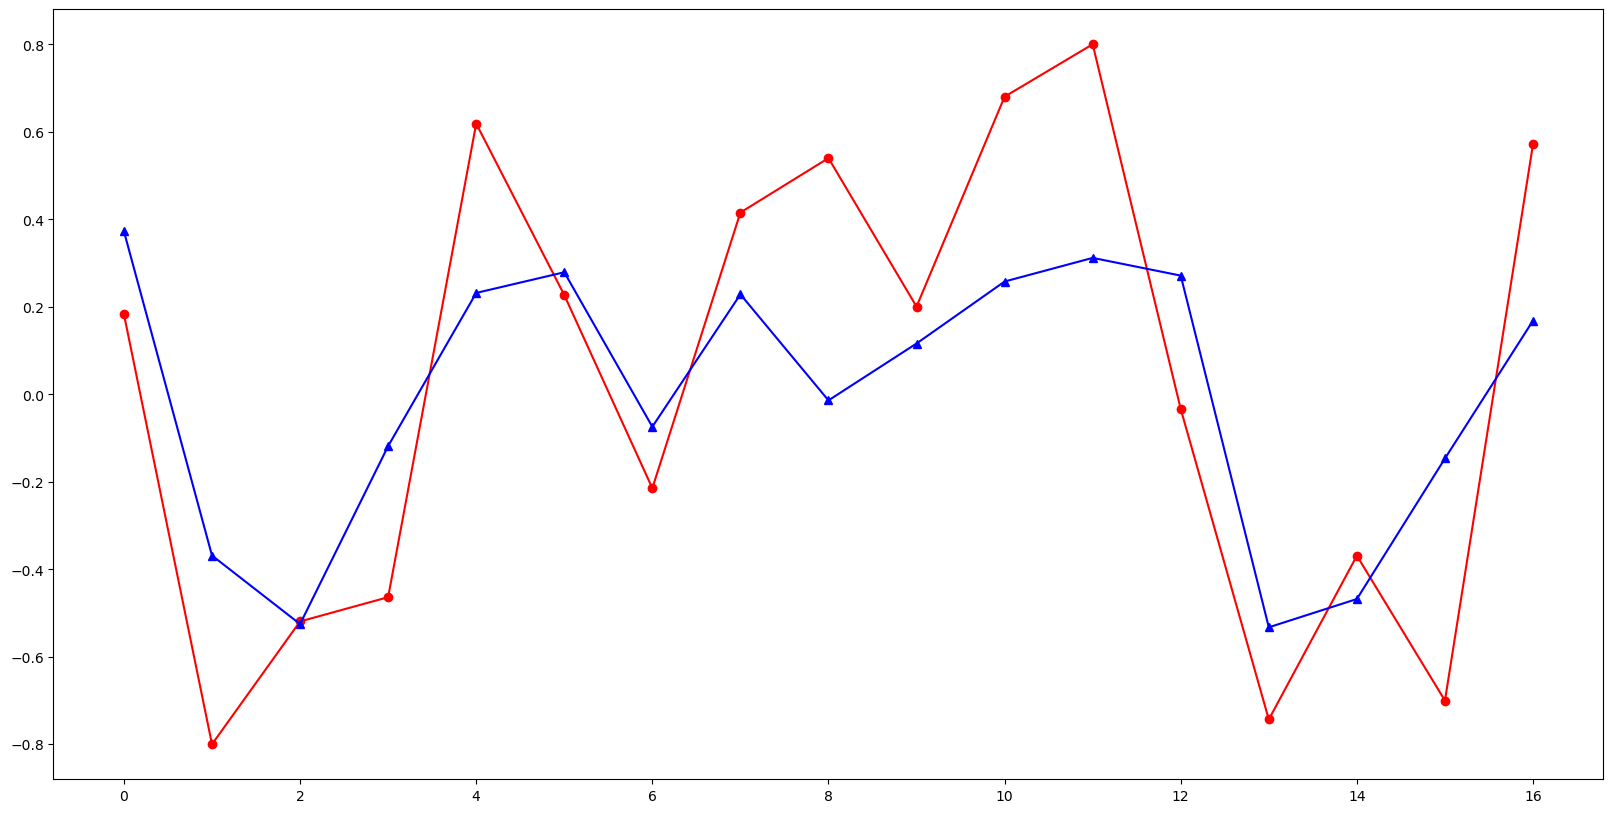

In [25]:
espacio = np.arange(0,objetivo_test.shape[0])
y_ = regressor.predict(conjunto_test)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_test, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()

In [26]:
np.sum( np.abs(objetivo_test[:] - y_[:]))/(len(objetivo_test))

8.691170924738284